In [ ]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#set to path to train_all.zip on the local system
!unzip /content/train_all.zip

In [ ]:
files_labels = []
img_dir = "/content/train_all/"
for fn in os.listdir(img_dir):
  steer = round(float(fn.split("_")[2]), 1)
  files_labels.append((img_dir + fn, steer))
df_labels = pd.DataFrame(files_labels, columns=["FileName","Steer"])
df_labels.head()

,FileName,Steer
0,/content/train_all/img_1662338429.8453093_-0.6...,-0.6
1,/content/train_all/img_1662338126.1024442_0_0....,0.0
2,/content/train_all/img_1661393157.2950583_0_0....,0.0
3,/content/train_all/img_1662337748.28064_0_0.1.jpg,0.0
4,/content/train_all/img_1662338364.8273005_0.4_...,0.4


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    df_labels,
    x_col="FileName",
    y_col="Steer",
    class_mode="raw",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_dataframe(
    df_labels,
    x_col="FileName",
    y_col="Steer",
    class_mode="raw",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 809 validated image filenames.
Found 202 validated image filenames.


In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64,))

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
#base_model.trainable = False

base_model.trainable = True
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.layers[150:]

In [ ]:
base_model.summary()

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.GlobalMaxPooling2D(),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=1) #tanh goes from -1 to 1
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=0.000075
              ),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          368672    
                                                                 
 dropout_4 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 global_max_pooling2d_2 (Glo  (None, 32)               0         
 balMaxPooling2D)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               8448      
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="{epoch:02d}-{val_loss:.2f}.hdf5",
    save_weights_only=True,
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=100,
                    callbacks=[model_checkpoint_callback, early_stop_callback],
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/100
13/13 [==============================] - 6s 263ms/step - loss: 4.3531 - mean_absolute_error: 1.6252 - val_loss: 0.3470 - val_mean_absolute_error: 0.4657
Epoch 2/100
13/13 [==============================] - 2s 181ms/step - loss: 1.2912 - mean_absolute_error: 0.9125 - val_loss: 0.3736 - val_mean_absolute_error: 0.4776
Epoch 3/100
13/13 [==============================] - 3s 193ms/step - loss: 0.6872 - mean_absolute_error: 0.6569 - val_loss: 0.2993 - val_mean_absolute_error: 0.4196
Epoch 4/100
13/13 [==============================] - 3s 194ms/step - loss: 0.4770 - mean_absolute_error: 0.5425 - val_loss: 0.2982 - val_mean_absolute_error: 0.4185
Epoch 5/100
13/13 [==============================] - 3s 194ms/step - loss: 0.3697 - mean_absolute_error: 0.4778 - val_loss: 0.2917 - val_mean_absolute_error: 0.4099
Epoch 6/100
13/13 [==============================] - 3s 196ms/step - loss: 0.3346 - mean_absolute_error: 0.4602 - val_loss: 0.2817 - val_mean_absolute_error: 0.4018
Epoch 7/10

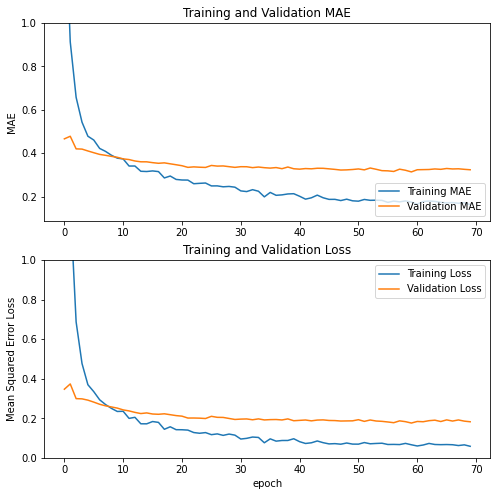

In [ ]:
acc = history.history['mean_absolute_error']
val_acc = history.history['val_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training MAE')
plt.plot(val_acc, label='Validation MAE')
plt.legend(loc='lower right')
plt.ylabel('MAE')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save_weights("chkpnt-1")

# Now prepare the model to run on the EdgeTPU by converting to TFLite, Quantizing and compiling for the EdgeTPU.

In [ ]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files("/content/train_all/*")
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
batch_images, batch_truth = next(val_generator)

prediction = model(batch_images)

keras_mae = tf.keras.metrics.MeanAbsoluteError()
keras_mae(prediction[:,0], batch_truth)

print("Raw model MAE: {:.3%}".format(keras_mae.result()))

Raw model MAE: 25.880%


In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
#batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_mae = tf.keras.metrics.MeanAbsoluteError()
tflite_mae(batch_prediction, batch_truth)
print("Quant TF Lite MAE: {:.3%}".format(tflite_mae.result()))


Quant TF Lite MAE: 32.500%


In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  84566      0 --:--:-- --:--:-- --:--:-- 84566
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,959 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:8 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Get:9 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 P

In [ ]:
! edgetpu_compiler mobilenet_v2_1.0_224_quant.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 948 ms.

Input model: mobilenet_v2_1.0_224_quant.tflite
Input size: 2.95MiB
Output model: mobilenet_v2_1.0_224_quant_edgetpu.tflite
Output size: 3.13MiB
On-chip memory used for caching model parameters: 3.36MiB
On-chip memory remaining for caching model parameters: 4.34MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_1.0_224_quant_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 
